<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial1.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial1.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 1: Aprendiendo a Predecir

---

# Objetivos del tutorial

El aprendizaje por refuerzo (RL) es un marco para definir y resolver un problema en el que un agente aprende a realizar acciones que maximicen la recompensa. El planteamiento del problema es el siguiente: un agente, biológico o artificial, observa el estado actual del mundo y selecciona una acción basada en ese estado. Al ejecutar una acción, el agente recibe una recompensa y utiliza esta información para mejorar sus acciones futuras. El aprendizaje por refuerzo proporciona descripciones formales y óptimas del aprendizaje. Estas descripciones se derivaron primero de estudios de comportamiento animal y luego se validaron cuando las cantidades formales utilizadas en el modelo se observaron en el cerebro de humanos y animales.

El aprendizaje por refuerzo es un marco amplio y tiene conexiones profundas con muchos temas tratados en NMA. Por ejemplo, la mayor parte del aprendizaje por refuerzo define el mundo como un problema de decisión de Markov, que se basa en dinámicas ocultas y control óptimo. En términos más generales, el aprendizaje por refuerzo puede verse como un marco que nos permite incorporar muchas ideas y formalismos de otras áreas como economía, psicología, informática, inteligencia artificial, etc. para definir algoritmos o modelos que puedan resolver problemas grandes y complejos con sólo una simple señal de recompensa.

En este tutorial, modelaremos al agente como un observador que aprende a predecir recompensas futuras. Este agente no realiza ninguna acción y, por tanto, no puede influir en la recompensa que recibe. Al predecir cuánta recompensa se deriva de cada estado, el agente puede aprender a identificar los mejores estados del mundo, es decir, aquellos que tienden a ser seguidos por la mayor recompensa.

Más específicamente, aprenderemos cómo estimar funciones de valor de estado en un paradigma de condicionamiento clásico utilizando el aprendizaje de Diferencia Temporal (TD, por _Temporal Difference_) y examinaremos los errores de TD en la presentación del estímulo condicionado e incondicionado (CS y US, por _Conditioned_ y _Unconditioned Stimulus_) bajo diferentes contingencias CS-US. . Estos ejercicios le permitirán comprender cómo se comportan los errores de predicción de recompensa (RPE, por _Reward Prediction Error_) en el condicionamiento clásico y qué deberíamos esperar si la dopamina representa un RPE "canónico" sin modelo (_model-free_).

Al final de este tutorial:
* Aprenderá a utilizar el modelo de acondicionamiento de retardo estándar.
* Comprenderás cómo los RPE se trasladan a CS
* Comprenderá cómo la variabilidad en el tamaño de la recompensa afecta los RPE
* Comprenderá cómo las diferencias en el tiempo de US-CS afectan los RPE

Los tutoriales 1 a 4 deberían tardar 3+ horas en completarse, aunque podría llevar más tiempo si eres completamente nuevo en este material y/o si estás interesado en estudiar todo el material adicional.

---
# Configuración

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

##  Configuración de Figura


In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Funciones de graficado


In [3]:
# @title Plotting Functions
from matplotlib import ticker

def plot_value_function(V, ax=None, show=True):
  """Plot V(s), the value function"""
  if not ax:
    fig, ax = plt.subplots()

  ax.stem(V)
  ax.set_ylabel('Value')
  ax.set_xlabel('State')
  ax.set_title("Value function: $V(s)$")

  if show:
    plt.show()


def plot_tde_trace(TDE, ax=None, show=True, skip=400):
  """Plot the TD Error across trials"""
  if not ax:
    fig, ax = plt.subplots()

  indx = np.arange(0, TDE.shape[1], skip)
  im = ax.imshow(TDE[:,indx])
  positions = ax.get_xticks()
  # Avoid warning when setting string tick labels
  ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
  ax.set_xticklabels([f"{int(skip * x)}" for x in positions])
  ax.set_title('TD-error over learning')
  ax.set_ylabel('State')
  ax.set_xlabel('Iterations')
  ax.figure.colorbar(im)
  if show:
    plt.show()


def learning_summary_plot(V, TDE):
  """Summary plot for Ex1"""
  fig, (ax1, ax2) = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [1, 2]})

  plot_value_function(V, ax=ax1, show=False)
  plot_tde_trace(TDE, ax=ax2, show=False)
  plt.tight_layout()
  plt.show()

##  Funciones y clases auxiliares


In [4]:
# @title Helper Functions and Classes

def reward_guesser_title_hint(r1, r2):
  """"Provide a mildly obfuscated hint for a demo."""
  if (r1==14 and r2==6) or (r1==6 and r2==14):
    return "Technically correct...(the best kind of correct)"

  if  ~(~(r1+r2) ^ 11) - 1 == (6 | 24): # Don't spoil the fun :-)
    return "Congratulations! You solved it!"

  return "Keep trying...."


class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        # Time step at which the conditioned stimulus is presented
        self.set_reward(reward_magnitude, reward_time)

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]


class MultiRewardCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that one randomly selected reward,
    magnitude, from a list, is delivered of a single fixed reward."""
  def __init__(self, n_steps, reward_magnitudes, reward_time=None):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: LIST of possible reward magnitudes.
        - reward_time: Single fixed reward time
      Uses numpy global random state.
      """
    super().__init__(n_steps, 1, reward_time)
    self.reward_magnitudes = reward_magnitudes

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward=np.random.choice(self.reward_magnitudes)
    return next_state, reward


class ProbabilisticCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that rewards are stochastically omitted."""
  def __init__(self, n_steps, reward_magnitude, reward_time=None, p_reward=0.75):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: Reward magnitudes.
        - reward_time: Single fixed reward time.
        - p_reward: probability that reward is actually delivered in rewarding state
      Uses numpy global random state.
      """
    super().__init__(n_steps, reward_magnitude, reward_time)
    self.p_reward = p_reward

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward*= int(np.random.uniform(size=1)[0] < self.p_reward)
    return next_state, reward

---
# Sección 1: Aprendizaje de diferencia temporal

__Ambiente:__

- El agente experimenta el entorno en episodios (también conocidos como ensayos o _trials_).
- Los episodios terminan con la transición al estado de intervalo entre pruebas (ITI o _inter-trial_interval_) y también se inician desde el estado ITI. Fijamos el valor de los estados terminales/ITI a cero.
- El entorno de condicionamiento clásico se compone de una secuencia de estados por los que el agente pasa de manera determinista. Comenzando en el Estado 0, el agente pasa al Estado 1 en el primer paso, del Estado 1 al Estado 2 en el segundo, y así sucesivamente. Estos estados representan el tiempo en lo que se llama representación de "línea de retardo aprovechada" (_tapped delay line_).
- Dentro de cada episodio, el agente recibe un CS (señal) y un US (recompensa).
- El CS (señal/estímulo condicionado) se presenta al final del primer cuarto del juicio. El US (la recompensa) se entrega poco después. El intervalo entre CS y US se especifica mediante "reward_time".
- El objetivo del agente es aprender a predecir las recompensas esperadas de cada estado en la prueba.

<br>

**Conceptos generales**

Referencia: McClelland, J. L., Rumelhart, D. E. (1989). Explorations in parallel distributed processing: A handbook of models, programs, and exercises. Chapter 9, MIT press. url: [web.stanford.edu/group/pdplab/pdphandbook/handbookch10.html](https://web.stanford.edu/group/pdplab/pdphandbook/handbookch10.html)

<br>

* Retorno $G_{t}$:recompensa acumulada futura en el momento $t$:
\begin{equation}
G_{t} = \sum \limits_{k = 0}^{\infty} \gamma^{k} r_{t+k+1}
\end{equation}
donde $r_{t}$ es la cantidad de recompensa recibida en el momento $t$, y $\gamma \in [0, 1]$ es un factor de descuento que especifica la relevancia en el presente de las recompensas futuras.
Notar que el retorno $G_{t}$ puede ser escrito de manera recursiva:
\begin{equation}
G_{t} = r_{t+1} + \gamma G_{t+1}
\end{equation}

* Estado $s$ describe el estado presente, típicamente obtenido de observaciones que el agente recibe del ambiente.

* Política (_policy_) $\pi$ es una especificación de como actúa el agente. $\pi(a|s)$ nos da la probabilidad de tomar la acción $a$ cuando estamos en el estado $s$.

* La función de valor (_value function_) $V_{\pi}(s_t=s)$ está definida como el retorno esperado empezando del estado $s$ y sucesivamente siguiendo la política $\pi$. En términos generales, la función de valor estima "qué tan bueno" es estar en el estado $s$ cuando se sigue la política $\pi$.

\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ G_{t}\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
& = \mathbb{E} [ r_{t+1} + \gamma G_{t+1}\; | \; s_t=s, a_{t:\infty}\sim\pi]
\end{align}

* Combinando lo anterior, tenemos:
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ r_{t+1} + \gamma V_{\pi}(s_{t+1})\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
&= \sum_a \pi(a|s) \sum_{r, s'}p(s', r)(r + V_{\pi}(s_{t+1}=s'))
\end{align}

<br>

**Aprendizaje de diferencia temporal (TD)**

*Con una [Suposición markoviana](https://en.wikipedia.org/wiki/Markov_property), podemos usar $V(s_{t+1})$ como indicador del verdadero valor del retorno $G_{t+1}$. Así, obtenemos una ecuación generalizada para calcular el error TD:
\begin{align}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{align}

* El error TD mide la discrepancia entre los valores en el momento $t$ y $t+1$. Una vez calculado el error TD, podemos realizar una "actualización de valor" para reducir la discrepancia del valor:

\begin{align}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{align}

* La velocidad a la que se reduce la discrepancia se especifica mediante una constante (también conocida como hiperparámetro) $\alpha$, llamada tasa de aprendizaje (_learning rate_).

<br>

**Definiciones (tl;dr):**

* Retorno:
\begin{equation}
G_{t} = \sum \limits_{k = 0}^{\infty} \gamma^{k} r_{t+k+1} = r_{t+1} + \gamma G_{t+1}
\end{equation}

* Error TD:
\begin{equation}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}

* Actualización de valor:
\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{equation}

## Ejercicio de programación 1: Aprendizaje TD con recompensas garantizadas

En este ejercicio, implementará aprendizaje TD para estimar la función de valor de estado en el paradigma de condicionamiento clásico. Las recompensas tienen una magnitud fija y se entregan con un retraso fijo después del estímulo condicionado, CS. Debe guardar los errores TD durante el aprendizaje (es decir, durante las pruebas) para que podamos visualizarlos después.

Para simular el efecto del CS, debes actualizar $V(s_{t})$ solo durante el período de retraso después de la CS. Este período está indicado por la variable booleana `is_delay`. Esto se puede implementar multiplicando la expresión para actualizar la función de valor por `is_delay`.

Utilice el código proporcionado para estimar la función de valor. Usaremos la clase auxiliar `ClassicalConditioning`.

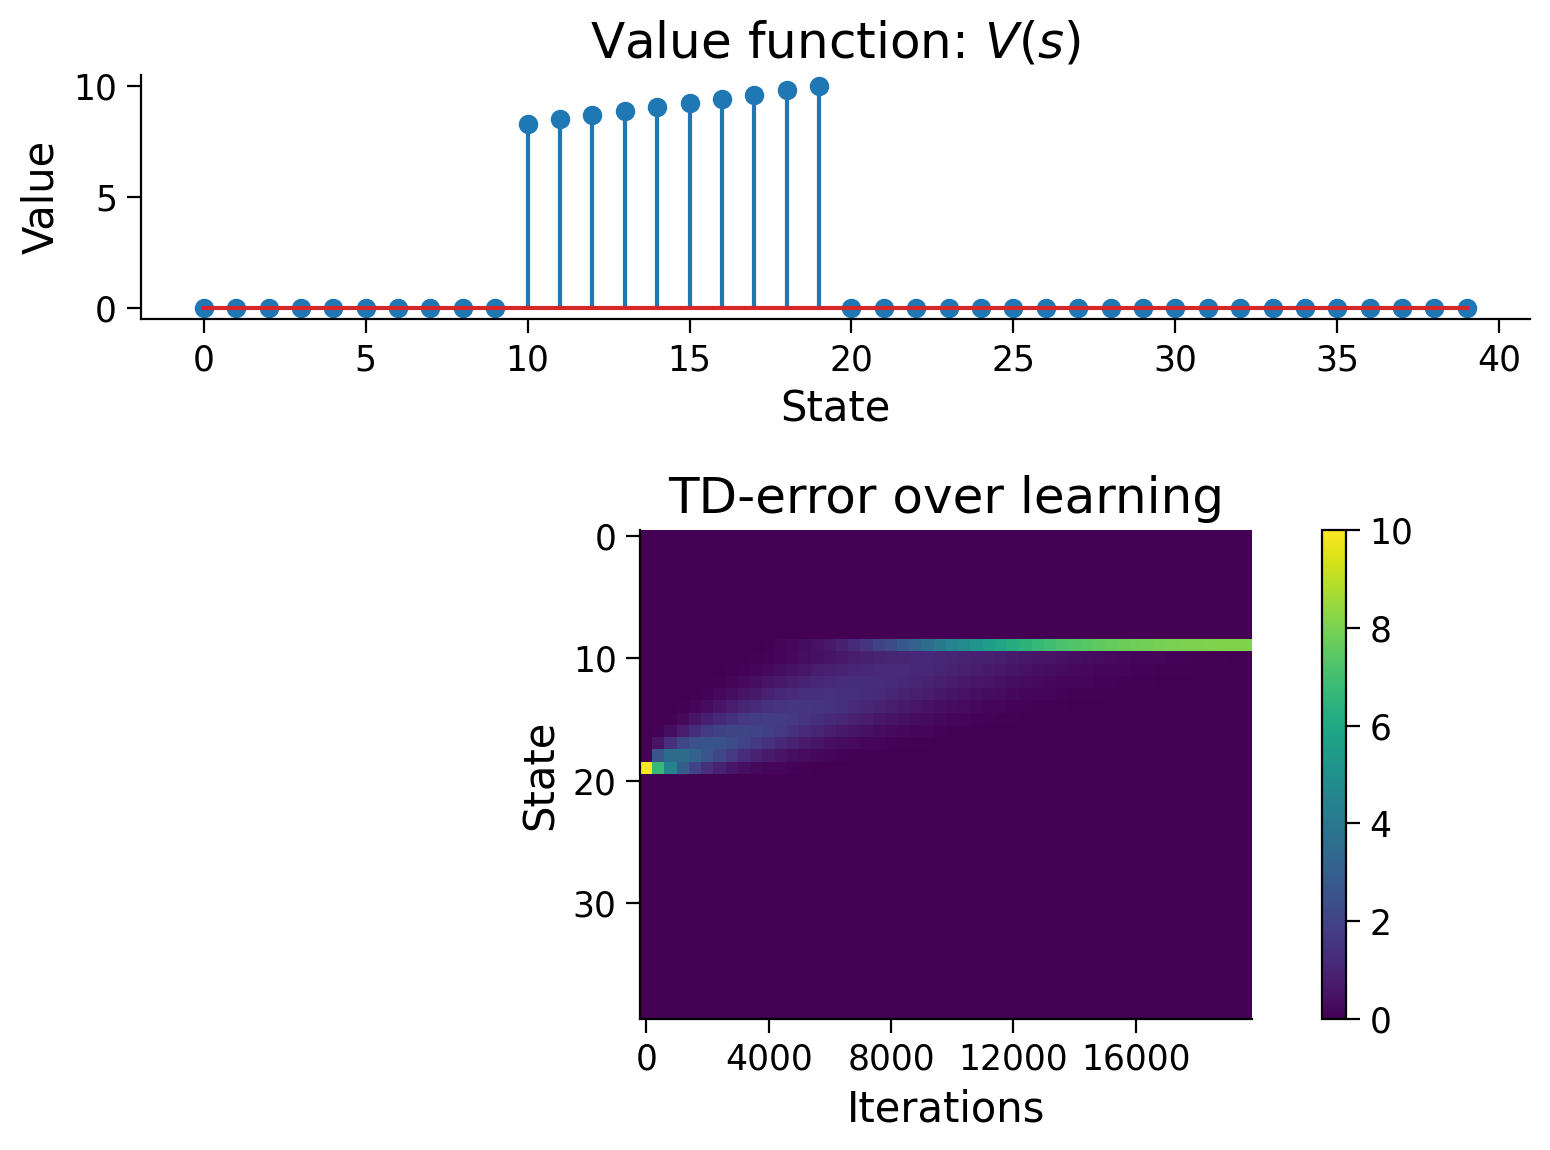

In [5]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
  """ Temporal Difference learning

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate

  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps) # Array to store values over states (time)
  TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

  for n in range(n_trials):

    state = 0 # Initial state
    for t in range(env.n_steps):

      # Get next state and next reward
      next_state, reward = env.get_outcome(state)

      # Is the current state in the delay period (after CS)?
      is_delay = env.state_dict[state][0]

      # Write an expression to compute the TD-error
      TDE[state, n] = (reward + gamma * V[next_state] - V[state])

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state

  return V, TDE


# Initialize classical conditioning class
env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)

# Perform temporal difference learning
V, TDE = td_learner(env, n_trials=20000)

# Visualize
# with plt.xkcd():
learning_summary_plot(V, TDE)

## Demo Interactivo 1.1: Transferencia de US a CS

Durante el condicionamiento clásico, la respuesta conductual del sujeto (p. ej., salivar) se transfiere del estímulo incondicionado (US; como el olor de una comida sabrosa) al estímulo condicionado (CS; como Pavlov tocando su campana) que la predice. Los errores de predicción de recompensas juegan un papel importante en este proceso al ajustar el valor de los estados de acuerdo con su rendimiento descontado esperado.

Recuerde que los errores TD vienen dados por:

\begin{equation}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{equation}

El período de retraso tiene recompensa cero, por lo que durante toda la fase de aprendizaje, los errores TD resultan de inconsistencias entre $V(s_{t+1})$ y $V(s_{t})$ (tenga en cuenta que el factor de descuento se establece a cero en este ejemplo). Los errores TD para un momento dado disminuyen una vez que $ V (s_ {t}) $ se acerca a $ V (s_ {t + 1}) $, pero eso hace que el error TD para el momento anterior aumente. Así, a lo largo del aprendizaje, los errores TD tenderán a moverse hacia atrás en el tiempo.

Utilice el siguiente widget para examinar cómo los errores de predicción de recompensas cambian con el tiempo.

Antes del entrenamiento (línea naranja), solo el estado de recompensa tiene un error de predicción de recompensa alto (línea azul). A medida que avanza el entrenamiento (control deslizante), los errores de predicción de recompensa cambian al estímulo condicionado, donde terminan cuando se completa la prueba (línea verde).

Las neuronas de dopamina, que se cree que contienen errores de predicción de recompensa _in vivo_, ¡muestran exactamente el mismo comportamiento!

¡Asegúrate de ejecutar esta celda para habilitar el widget!

In [6]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

n_trials = 20000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=5000, min=0, max=n_trials-1 , step=1, description="Trial #")):
  if 'TDE' not in globals():
    print("Complete Exercise 1 to enable this interactive demo!")
  else:

    fig, ax = plt.subplots()
    ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
    ax.stem(TDE[:, 0], linefmt='C1-', markerfmt='C1d', basefmt=' ',
            label="Before Learning (Trial 0)")
    ax.stem(TDE[:, -1], linefmt='C2-', markerfmt='C2s', basefmt=' ',
            label=r"After Learning (Trial $\infty$)")
    ax.stem(TDE[:, trial], linefmt='C0-', markerfmt='C0o', basefmt=' ',
            label=f"Trial {trial}")

    ax.set_xlabel("State in trial")
    ax.set_ylabel("TD Error")
    ax.set_title("Temporal Difference Error by Trial")
    ax.legend()
    plt.show()

interactive(children=(IntSlider(value=5000, description='Trial #', max=19999), Output()), _dom_classes=('widge…

## Demo Interactivo 1.2: Tasas de aprendizaje y factores de descuento

Nuestro agente aprendiendo con TD tiene dos parámetros que controlan cómo aprende: $\alpha$, la tasa de aprendizaje y $\gamma$, el factor de descuento. En el Ejercicio 1, configuramos estos parámetros en $\alpha=0.001$ y $\gamma=0.98$ para usted. Aquí, investigará cómo el cambio de estos parámetros altera lo que aprende el modelo por TD-learning.

Antes de habilitar la demostración interactiva a continuación, tómese un momento para pensar en las funciones de estos dos parámetros. $\alpha$ controla el tamaño de las actualizaciones de la función Valor producidas por cada error TD. En nuestro mundo simple y determinista, ¿afectará esto el modelo final que aprendamos? ¿Un $\alpha$ más grande es necesariamente mejor en entornos más complejos y realistas?

La tasa de descuento $\gamma$ aplica una ponderación que decrece exponencialmente a los retornos que se producen en el futuro, en lugar del paso de tiempo presente. ¿Cómo afecta esto al modelo que aprendemos? ¿Qué sucede cuando $\gamma=0$ o $\gamma \geq 1$?

Utilice el widget para probar sus hipótesis.




¡Asegúrate de ejecutar esta celda para habilitar el widget!

In [7]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

@widgets.interact
def plot_summary_alpha_gamma(alpha=widgets.FloatSlider(value=0.0001, min=0.0001,
                                                       max=0.1, step=0.0001,
                                                       readout_format='.4f',
                                                       description="alpha"),
                             gamma=widgets.FloatSlider(value=0.980, min=0,
                                                       max=1.1, step=0.010,\
                                                       description="γ")):
  env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
  try:
    V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma,
                                      alpha=alpha)
  except NotImplementedError:
    print("Finish Exercise 1 to enable this interactive demo")

  learning_summary_plot(V_params,TDE_params)

interactive(children=(FloatSlider(value=0.0001, description='alpha', max=0.1, min=0.0001, readout_format='.4f'…

---
# Sección 2: TD-learning con diferentes magnitudes de recompensa

En el ejercicio anterior, el entorno era lo más sencillo posible. En cada prueba, el CS predijo la misma recompensa, al mismo tiempo, con un 100% de certeza. En los próximos ejercicios, complicaremos progresivamente el entorno y examinaremos el comportamiento del alumno TD.

## Demos Interactiva 2: Haciendo coincidir las funciones de valor

En primer lugar, reemplazaremos el entorno por uno que otorgue una de varias recompensas, elegidas al azar. A continuación se muestra la función de valor final $V$ para un agente TD que fue entrenado en un entorno donde el CS predijo una recompensa de o 6 o 14 unidades (ambas recompensas eran igualmente probables).

¿Puedes encontrar otro par de recompensas que hagan que el agente aprenda la misma función de valor? Suponga que cada recompensa se otorgará el 50% del tiempo.

Consejos:
* Considere cuidadosamente la definición de la función de valor $V$. Esto se puede resolver analíticamente.
* No es necesario cambiar $\alpha$ o $\gamma$.
* Debido a la aleatoriedad, puede haber una pequeña variación.

In [8]:
# @markdown Make sure you execute this cell to enable the widget!

# @markdown Please allow some time for the new figure to load

n_trials = 20000
np.random.seed(2020)
rng_state = np.random.get_state()
env = MultiRewardCC(40, [6, 14], reward_time=10)
V_multi, TDE_multi = td_learner(env, n_trials, gamma=0.98, alpha=0.001)

@widgets.interact
def reward_guesser_interaction(r1 = widgets.IntText(value=0, min=0, max=50, description="Reward 1"),
                               r2 = widgets.IntText(value=0, min=0, max=50, description="Reward 2")):
  try:
    env2 = MultiRewardCC(40, [r1, r2], reward_time=10)
    V_guess, _ = td_learner(env2, n_trials, gamma=0.98, alpha=0.001)
    fig, ax = plt.subplots()
    m, l, _ = ax.stem(V_multi, linefmt='y-', markerfmt='yo',
                      basefmt=' ', label="Target")
    m.set_markersize(15)
    m.set_markerfacecolor('none')
    l.set_linewidth(4)
    m, _, _ = ax.stem(V_guess, linefmt='r', markerfmt='rx',
                      basefmt=' ', label="Guess")
    m.set_markersize(15)

    ax.set_xlabel("State")
    ax.set_ylabel("Value")
    ax.set_title(f"Guess V(s)\n{reward_guesser_title_hint(r1, r2)}")
    ax.legend()
    plt.show()
  except NotImplementedError:
    print("Please finish Exercise 1 first!")

interactive(children=(IntText(value=0, description='Reward 1'), IntText(value=0, description='Reward 2'), Outp…

## ¡A pensar! 2: Examinando el error TD

Ejecute la siguiente celda para trazar los errores de TD de nuestro entorno de recompensas múltiples. ¿Aparece una nueva característica en esta traza? ¿Qué es? ¿Por que sucede?

Ejecuta la celda

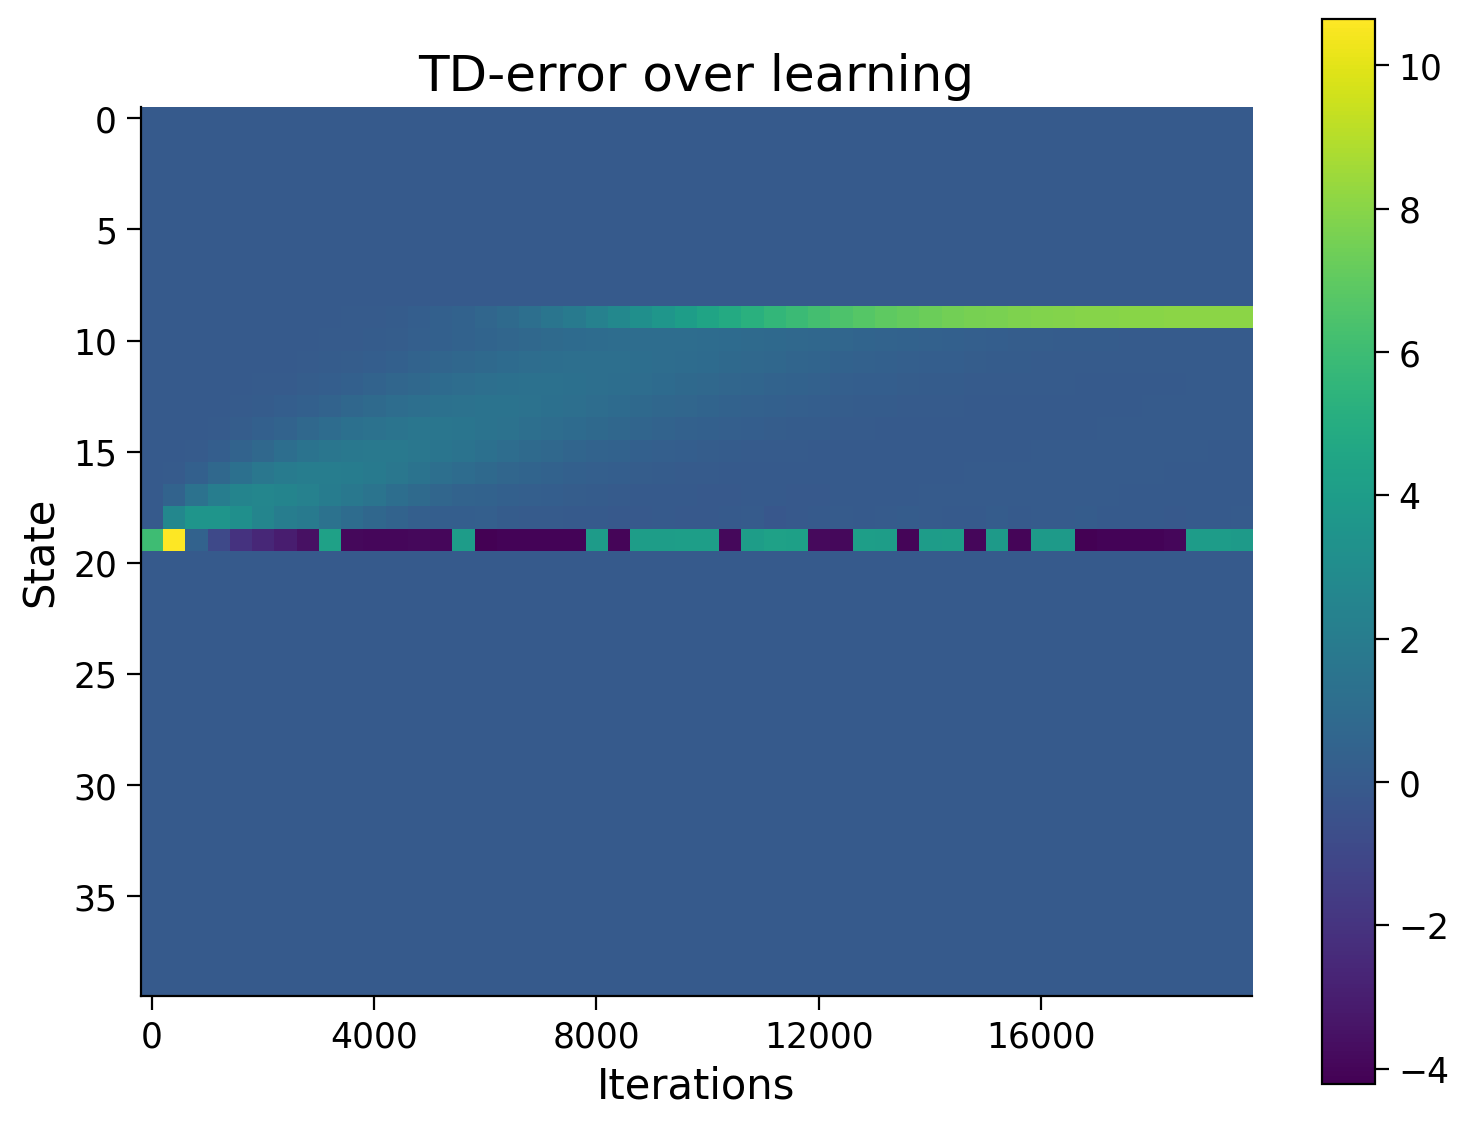

In [9]:
# @markdown Ejecuta la celda
plot_tde_trace(TDE_multi)

---
# Sección 3: TD-learning con recompensas probabilísticas


## ¡A pensar! 3: Recompensas probabilísticas


En este entorno, volveremos a entregar una recompensa única de diez unidades. Sin embargo, se entregará de forma intermitente: en el 20 por ciento de las pruebas, se mostrará el CS pero el agente no recibirá la recompensa habitual; el 80% restante se procederá como de costumbre.

Ejecute la siguiente celda para simular. Recuerde que anteriormente en el cuaderno vimos que cambiar $\alpha$ tenía poco efecto en el aprendizaje en un entorno determinista. En la siguiente simulación, $\alpha$ se establece en 1. ¿Qué sucede cuando la tasa de aprendizaje se establece en un valor tan grande en una configuración de recompensa estocástica? ¿Parece que alguna convergerá en algún momento?

Con una alta tasa de aprendizaje, la función de valor rastrea cada recompensa observada y cambia rápidamente cada vez que hay un error en la predicción de la recompensa. En un caso de escenario probabilístico, este comportamiento da como resultado que la función de valor cambie demasiado rápido y nunca se estabilice (converja). El uso de una tasa de aprendizaje baja puede estabilizar la función de valor al suavizar cualquier variación en la señal de recompensa, lo que hace que la función de valor converja a la recompensa promedio con el tiempo. Sin embargo, utilizar una tasa de aprendizaje baja puede resultar en un aprendizaje lento.

Para obtener lo mejor de todos los mundos, suele ser útil utilizar una tasa de aprendizaje alta desde el principio (produciendo un aprendizaje rápido) y reducir la tasa de aprendizaje gradualmente a lo largo del aprendizaje (de modo que la función de valor converja con la recompensa promedio). A esto a veces se le llama "programa de tasa de aprendizaje" (_learning rate schedule_).

Ejecute esta celda para visualizar la función de valor y los errores TD cuando `alpha = 1`

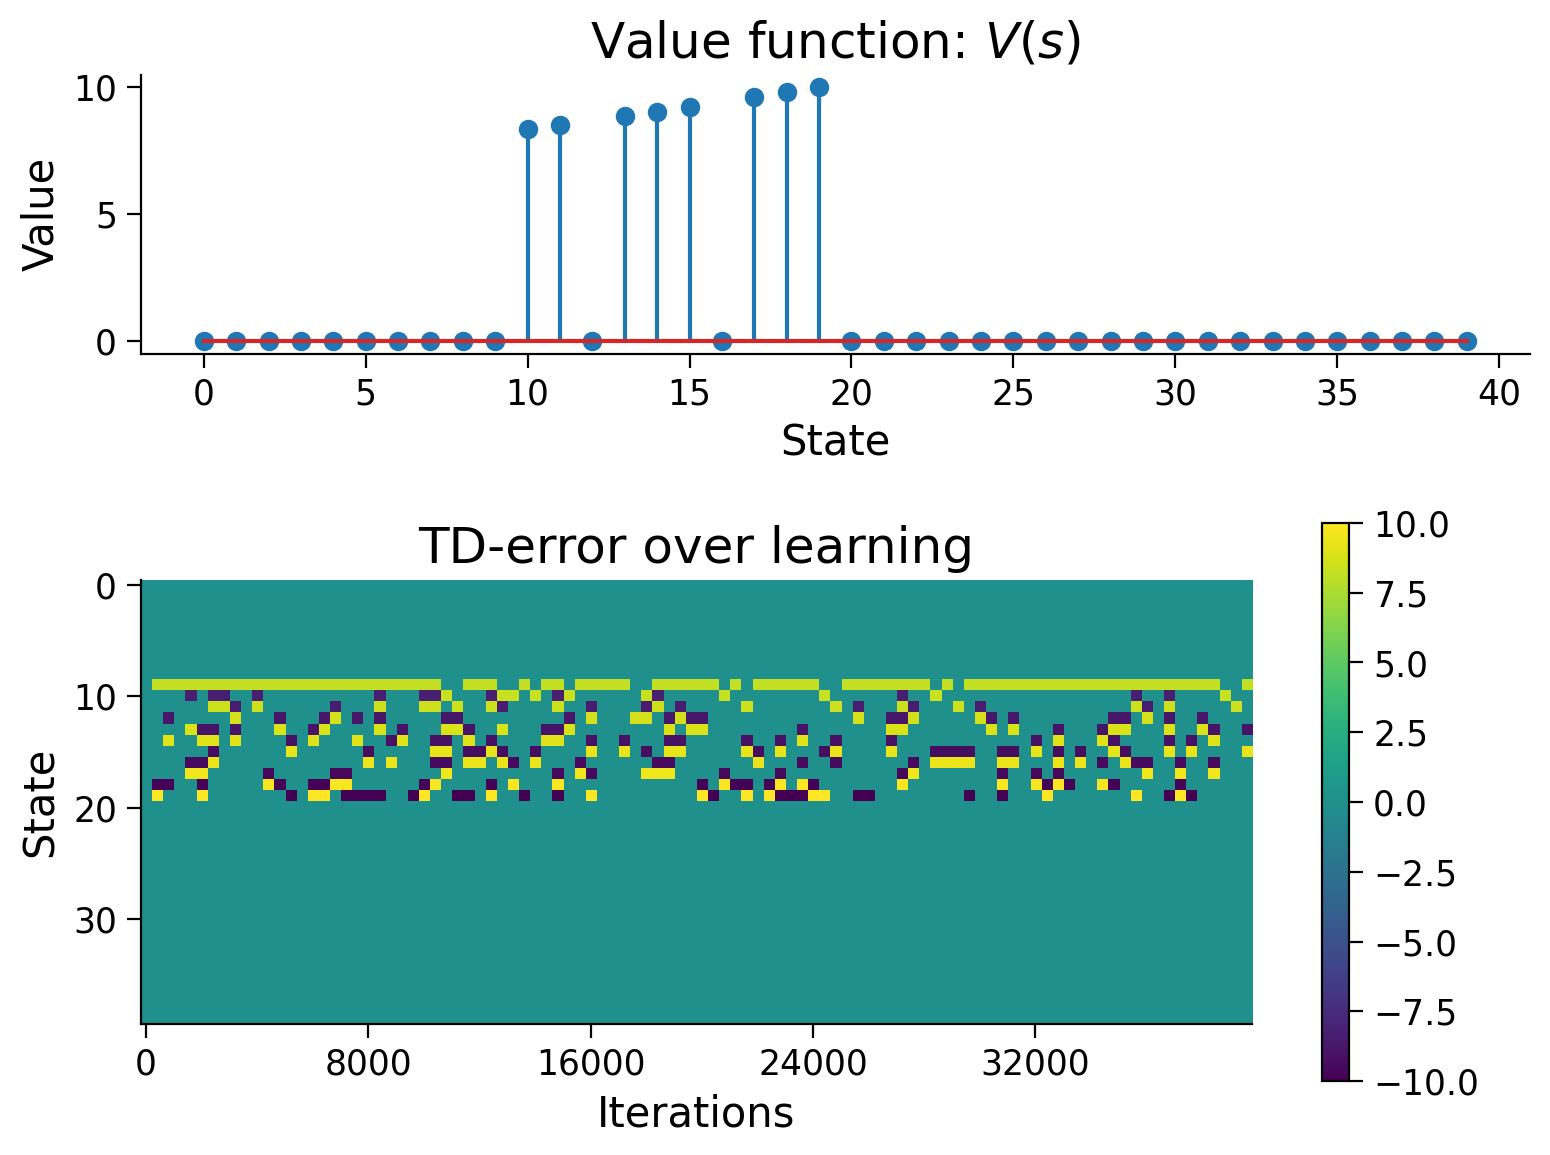

In [10]:
# @markdown Execute this cell to visualize the value function and TD-errors when `alpha=1`
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                        p_reward=0.8)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=1)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
  print("Please finish Exercise 1 first")

Ejecute esta celda para visualizar la función de valor y los errores TD cuando `alpha=0.2`

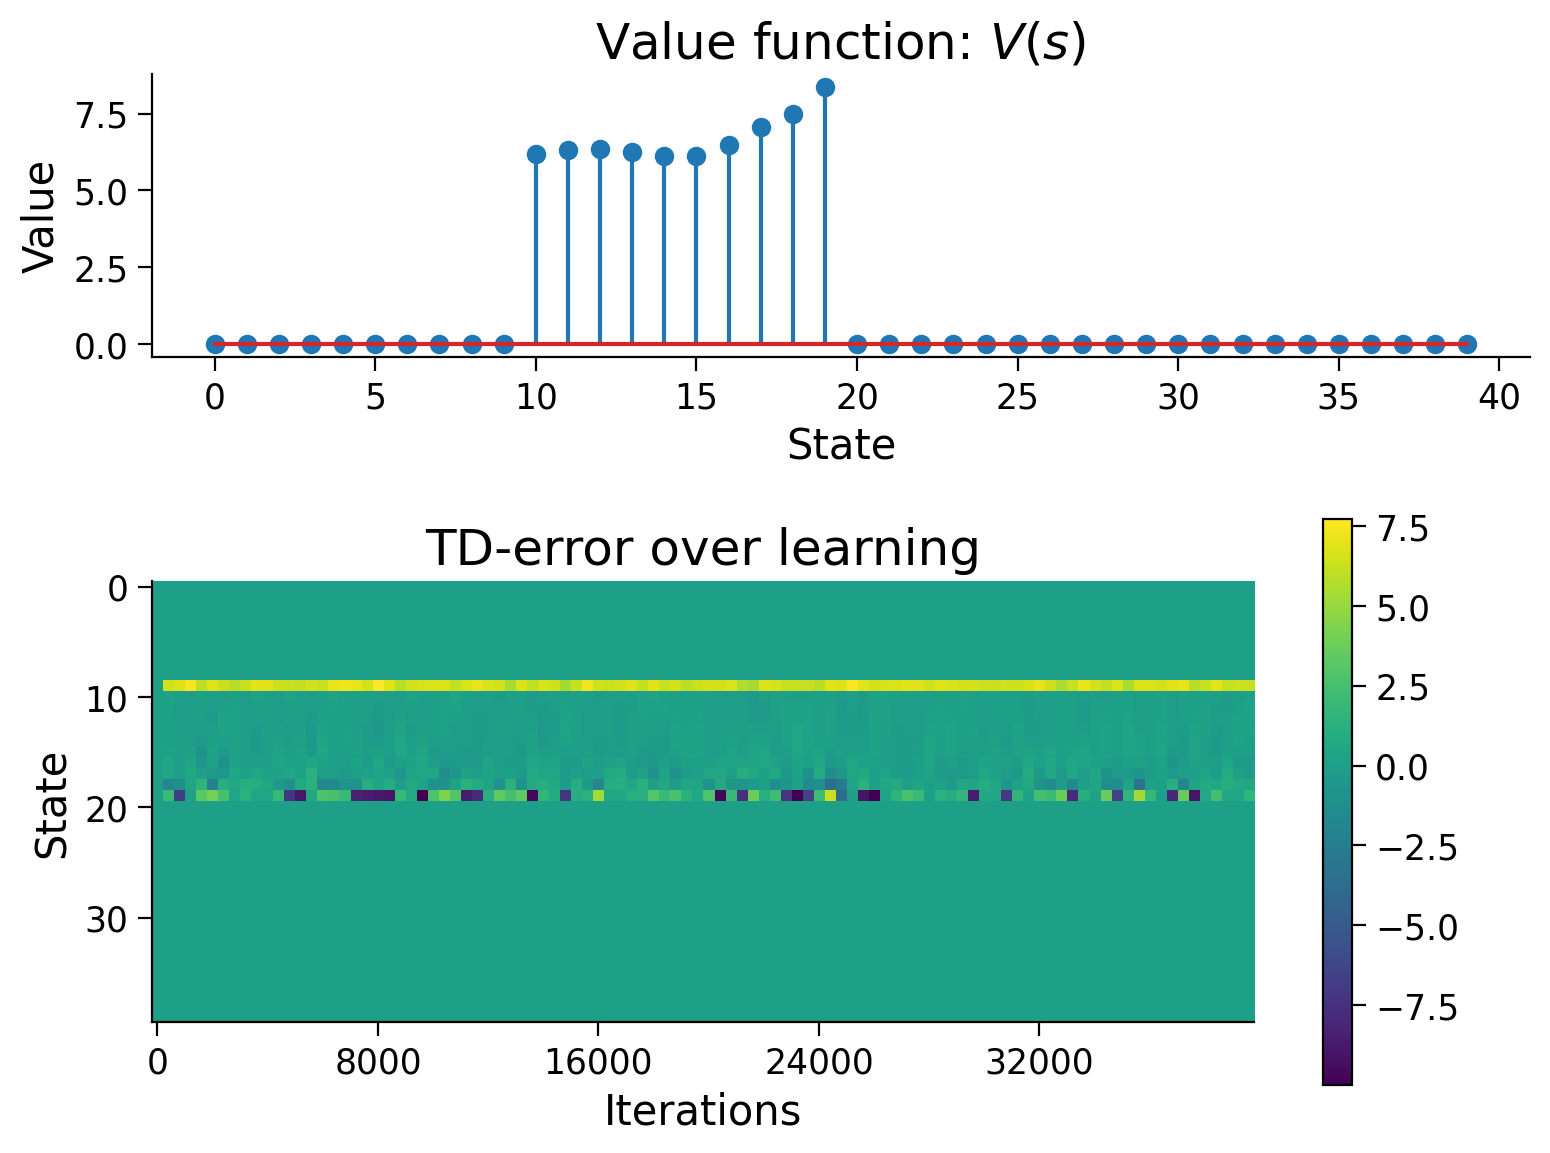

In [11]:
# @markdown Execute this cell to visualize the value function and TD-errors when `alpha=0.2`
np.random.set_state(rng_state)  # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                        p_reward=0.8)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=.2)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
  print("Please finish Exercise 1 first")

---
# Resumen


En este cuaderno, desarrollamos un agente simple que aprendió por TD-learning y examinamos cómo evolucionan sus representaciones de estado y errores de predicción de recompensas durante el entrenamiento. Al manipular su entorno y sus parámetros ($\alpha$, $\gamma$), desarrollaste una intuición sobre cómo se comporta.

Este modelo simple se parece mucho al comportamiento de sujetos que se someten a tareas de condicionamiento clásico y a las neuronas de dopamina que pueden subyacer a ese comportamiento. Es posible que haya implementado TD-reset o haya utilizado el modelo para recrear un error experimental común. La regla de actualización utilizada aquí ha sido ampliamente estudiada durante [más de 70 años] (https://www.pnas.org/content/108/Supplement_3/15647) como una posible explicación del aprendizaje artificial y biológico.

Sin embargo, es posible que hayas notado que falta algo en este cuaderno. Calculamos cuidadosamente el valor de cada estado, pero no lo usamos para hacer nada. ¡El uso de valores para planificar _**Acciones**_ es el próximo paso!

---
# Bonus

## Bonus 1: Eliminando el CS

En el ejercicio de codificación 1, (deberías haber) incluido un término que depende del estímulo condicionado. Quítelo y vea qué pasa. ¿Entiendes por qué?
Este fenómeno a menudo engaña a las personas que intentan entrenar animales. ¡Cuidado!